# Prior Predictive Checks
In this notebook, we compare different priors and what they mean for our model. In particular, we look at flat priors, weakly informative priors and informative priors.
If you want to know more about which priors and what prior parameters are recommended for which kind of model, check the [prior recommendation](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) by the Stan team.

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import bambi as bmb
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, plot_price_area
from projects.common.berlin_housing.utils.data_utils import load_data
from projects.common.berlin_housing.utils.data_utils import destandardize_area, destandardize_price, load_data, standardize_area
from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, draw_model_plot

DATA_DIR = PROJECT_DIR / 'data'  / 'berlin_housing' / 'interim_data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/berlin_housing/interim_data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
bambi     : 0.6.3
pandas    : 1.3.2
seaborn   : 0.11.2
numpy     : 1.19.5
arviz     : 0.11.2
xarray    : 0.19.0
matplotlib: 3.4.3
pymc3     : 3.11.4



In [3]:
df_orig, _, _ = load_data(kind="rents")
df_orig['rent_std'] = StandardScaler().fit_transform(df_orig[['rent']])
df_orig = df_orig[df_orig['rent'] < 7500]
# pymc chokes on raw rent, but is OK on rent / 100 
df_orig['rent_s'] = df_orig['rent'] / 100
df_orig['living_space_std'] = StandardScaler().fit_transform(df_orig[['living_space']])
target = 'rent_s'
df_orig.head()

,zip,rent,rent_s,log_rent,log_rent_s,sqm_rent,log_sqm_rent,log_sqm_rent_s,living_space,living_space_s,offer_year,const_year,const_year_s,flattype,interior_qual,zip_code,rent_std,living_space_std
59,12103,941.0,9.410,6.846943,-0.037463,30.354839,3.412956,2.350673,31.00,-1.145711,2019,2019.0,1.152406,NaN,NaN,84,-0.233760,-1.194297
75,14109,1399.7,13.997,7.244013,0.651780,16.999028,2.833156,0.728184,82.34,-0.002587,2019,1920.0,-0.933787,apartment,sophisticated,199,0.263925,0.011171
84,13086,830.0,8.300,6.721426,-0.255338,8.251317,2.110373,-1.294424,100.59,0.403763,2019,1912.0,-1.102368,ground_floor,normal,148,-0.354194,0.439683
86,10785,3417.6,34.176,8.136694,2.201314,16.000000,2.772589,0.558695,213.60,2.920016,2019,2018.0,1.131333,penthouse,sophisticated,55,2.453326,3.093170
136,12057,490.0,4.900,6.194405,-1.170151,10.000000,2.302585,-0.756545,49.00,-0.744927,2019,1972.0,0.161991,apartment,normal,79,-0.723090,-0.771655


In [26]:
df_orig.describe()

,rent,rent_s,log_rent,log_rent_s,sqm_rent,log_sqm_rent,log_sqm_rent_s,living_space,living_space_s,offer_year,const_year,const_year_s,zip_code,rent_std,living_space_std
count,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,6267.000000,6267.000000,7244.000000,7244.000000,7.244000e+03
mean,1134.802105,11.348021,6.863671,-0.008427,13.982292,2.571216,-0.004820,81.864215,-0.013181,2018.740199,1964.287538,-0.000531,97.379625,-0.023487,-1.240801e-16
std,763.917138,7.639171,0.565856,0.982226,5.728467,0.355463,0.994715,42.592192,0.948347,0.438556,47.452646,0.999953,64.874418,0.828843,1.000069e+00
min,178.160000,1.781600,5.182682,-2.926322,3.098963,1.131067,-4.034875,8.000000,-1.657823,2018.000000,1097.000000,-18.276583,0.000000,-1.061434,-1.734339e+00
25%,630.000000,6.300000,6.445720,-0.733915,10.073513,2.309909,-0.736049,56.000000,-0.589067,2018.000000,1911.000000,-1.123441,31.000000,-0.571192,-6.072944e-01
50%,913.830000,9.138300,6.817645,-0.088320,13.000000,2.564949,-0.022355,72.000000,-0.232815,2019.000000,1976.000000,0.246282,102.000000,-0.263239,-2.316128e-01
75%,1409.700000,14.097000,7.251132,0.664137,16.604167,2.809654,0.662416,96.207500,0.306183,2019.000000,2012.000000,1.004897,152.000000,0.274775,3.367818e-01
max,7000.000000,70.000000,8.853665,3.445848,76.250000,4.334017,4.928136,542.530000,10.243891,2019.000000,2020.000000,1.173479,210.000000,6.340195,1.081648e+01


## Flat priors
The idea behind flat priors is to have uninformative priors and thus be (supposedly) more objective/less subjective.

Note that some people call only unproper priors as flat priors. These are priors that have equal probability density everywhere and are thus not a real probability distribution (and are hence called unproper priors). These unproper priors mostly still lead to a valid and proper posterior. The flat priors I'm using here are then sometimes called very vague prior.

In [4]:
df = df_orig.copy()

In [5]:
with pm.Model() as flat_prior:
    alpha = pm.Normal("alpha", mu=0, sd=100)
    beta = pm.Normal("beta", mu=0, sd=100)
    mu = alpha + beta*df["living_space_s"]
    
    sigma = pm.Exponential("sigma", 1/100)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df[target])
    
    flat_prior = pm.sample_prior_predictive()
    # flat_trace = pm.sample(draws=50, tune=50)
    # this is only until this issue is fixed: https://github.com/arviz-devs/arviz/issues/822
    # since we're not fitting data for a prior predictive check, it's not necessary to sample

Just for comparison, a standard normal prior.

In [6]:
with pm.Model() as normal_prior:             # I guess I also could have just used numpy to generate the distribution
    alpha = pm.Normal("alpha", mu=0, sd=1)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*df["living_space_s"]
    
    sigma = pm.Exponential("sigma", 1)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df[target])
    
    normal_prior = pm.sample_prior_predictive()
    # normal_trace = pm.sample(draws=50, tune=50)

In [7]:
# flat_data = az.from_pymc3(trace = flat_trace, prior = flat_prior )
# normal_data = az.from_pymc3(trace = normal_trace, prior=normal_prior )
flat_data = az.from_pymc3(prior = flat_prior )
normal_data = az.from_pymc3(prior=normal_prior )

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


In [8]:
flat_data

Inference data with groups:
	> prior

In [9]:
normal_data

Inference data with groups:
	> prior

Visualizing the prior helps to understand what they mean.

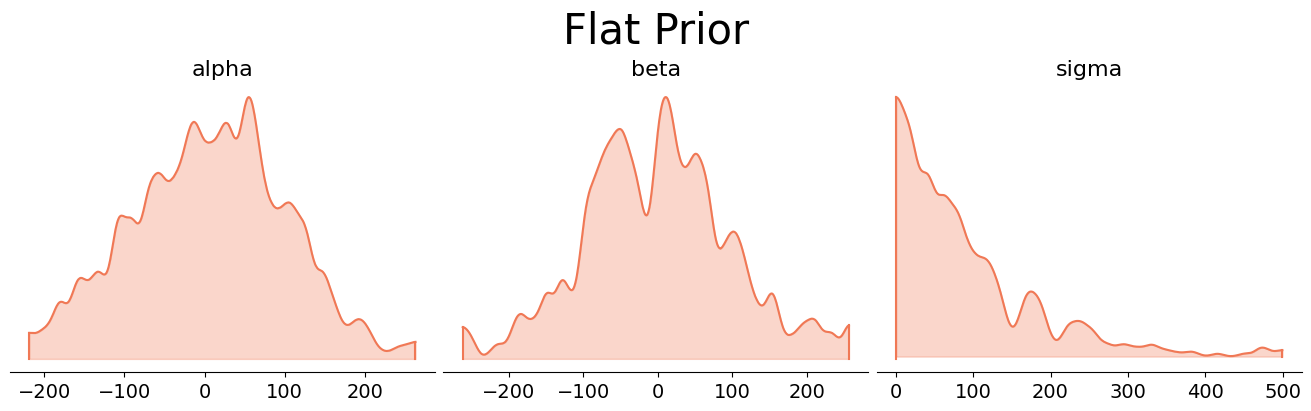

In [10]:
ax = az.plot_density(flat_data, group="prior",
                     data_labels = ["flat"],
                     var_names = ["alpha", "beta", "sigma"],
                     shade=0.3, bw=8, figsize=(13,4), hdi_prob=0.99,
                     colors="#f07855",  point_estimate=None)
# ax[0].set_title("alpha", fontdict={'fontsize': 20})
# ax[1].set_title("beta", fontdict={'fontsize': 20})
# ax[2].set_title("sigma", fontdict={'fontsize': 20})
# ax[0].tick_params("x", labelsize=16)
# ax[1].tick_params("x", labelsize=16)
# ax[2].tick_params("x", labelsize=16)
# ax[0].set_xlabel(" ", fontdict={"fontsize": 18}, labelpad=15)
# ax[1].set_xlabel(" ", fontdict={"fontsize": 18}, labelpad=15)
# ax[2].set_xlabel(" ", fontdict={"fontsize": 18}, labelpad=15)
plt.suptitle("Flat Prior", fontsize=30)
plt.show()

When we compare this prior with a standard normal distribution, it is easy to see why this kind of prior is called flat.

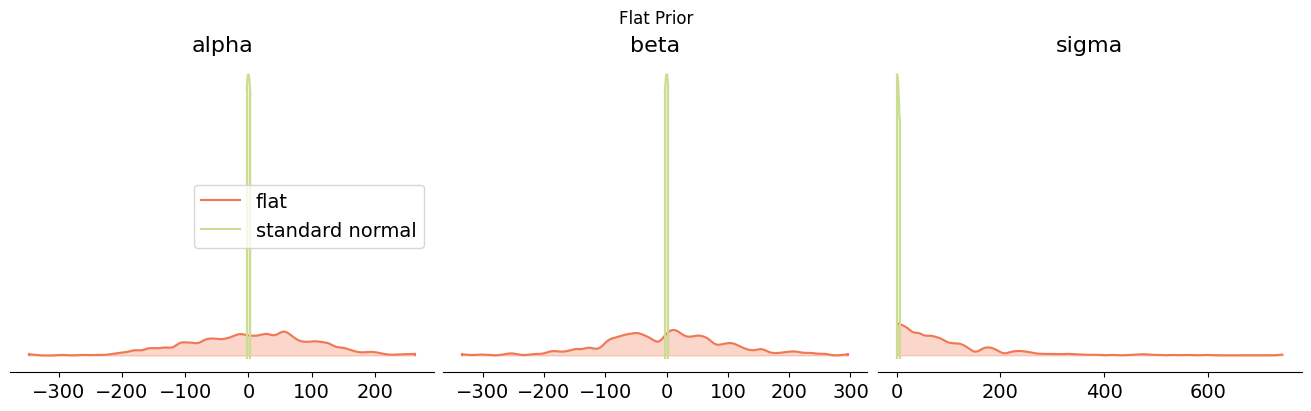

In [11]:
ax = az.plot_density([flat_data, normal_data], group="prior",
                data_labels = ["flat", "standard normal"] ,
               var_names = ["alpha", "beta", "sigma"],
               shade=0.3, bw=8, figsize=(13,4), hdi_prob=1,
                    colors=["#f07855", "#cbdd92"],  point_estimate=None)
# ax[0].legend(frameon=False, prop={'size': 18}, markerscale=3., loc="upper left")
# ax[0].set_title("alpha", fontdict={'fontsize': 20})
# ax[1].set_title("beta", fontdict={'fontsize': 20})
# ax[2].set_title("sigma", fontdict={'fontsize': 20})
# ax[0].set_xlabel(" ", fontdict={"fontsize": 18}, labelpad=15)
# ax[1].set_xlabel(" ", fontdict={"fontsize": 18}, labelpad=15)
# ax[2].set_xlabel(" ", fontdict={"fontsize": 18}, labelpad=15)
plt.suptitle("Flat Prior")
plt.show()

When doing prior checks, it is always very important to know the scale of your data. 
For this use case, I scaled the outcome variable by dividing by 100,000. That is, $y$ the price variable is the home price in 100,000€. 
Furthermore, I standardized the living area so that our intercept, the $\alpha$ parameter represents the price of an average home (in 100,000€).
Since $\beta$ is standardized, the slope parameter $\beta$ represents the change in the price if the living area changes by a standard deviation (that is 76sqm).

### Notes for rental data
+ scaled by dividing by 100

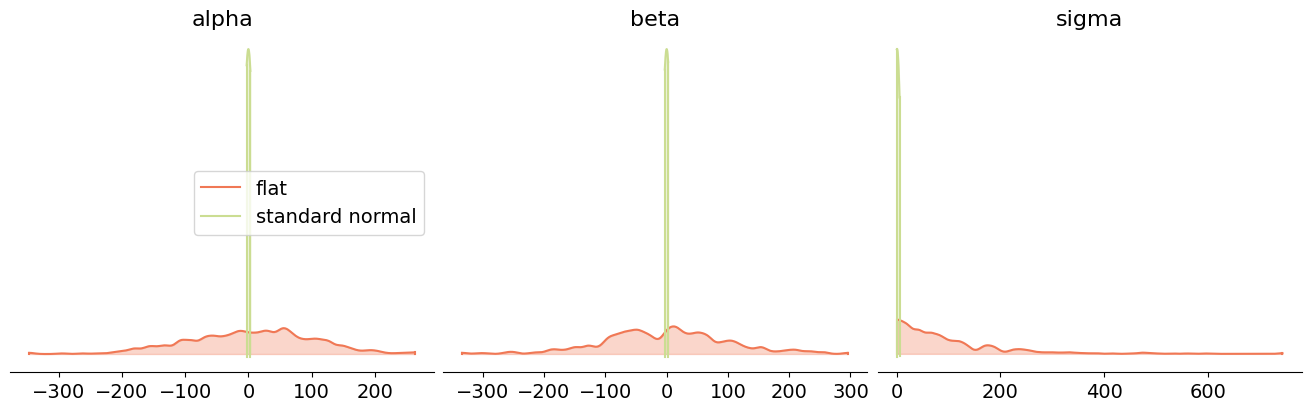

In [12]:
ax = az.plot_density([flat_data, normal_data], group="prior",
                data_labels = ["flat", "standard normal"] ,
               var_names = ["alpha", "beta", "sigma"],
               shade=0.3, bw=8, figsize=(13,4), hdi_prob=1,
                    colors=["#f07855", "#cbdd92"],  point_estimate=None)
# ax[0].legend(frameon=False, prop={'size': 18}, markerscale=3., loc="upper left")
# ax[0].set_title("alpha", fontdict={'fontsize': 20})
# ax[1].set_title("beta", fontdict={'fontsize': 20})
# ax[2].set_title("sigma", fontdict={'fontsize': 20})
# ax[0].set_xlabel("[Price of avg house in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[1].set_xlabel("[Price change in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[2].set_xlabel("[Price spread in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# plt.suptitle("Flat Prior")
# plt.show()

Since we're working with a simple linear model with only one predictor, the best way to understand these priors is to plot the resulting model.

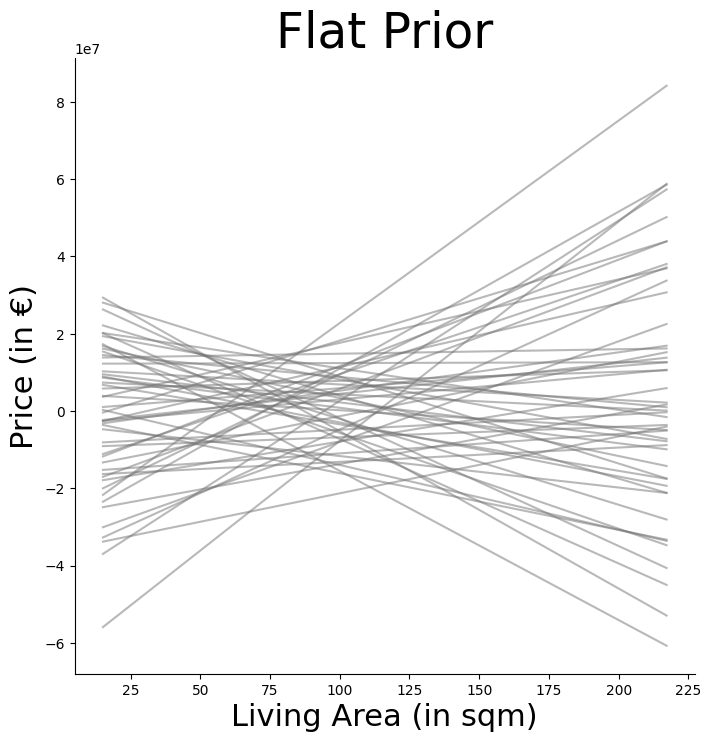

In [13]:
np.random.seed(2405)

fig, ax = draw_model_plot(flat_prior, title="Flat Prior")
plt.show()

Ideally, we should pick priors before seeing our without consulting our data. A good way to get the priors, is to make use of our external knowledge. We can for example google  what was the most expensive flat sold in Berlin. This gives a good reference point.

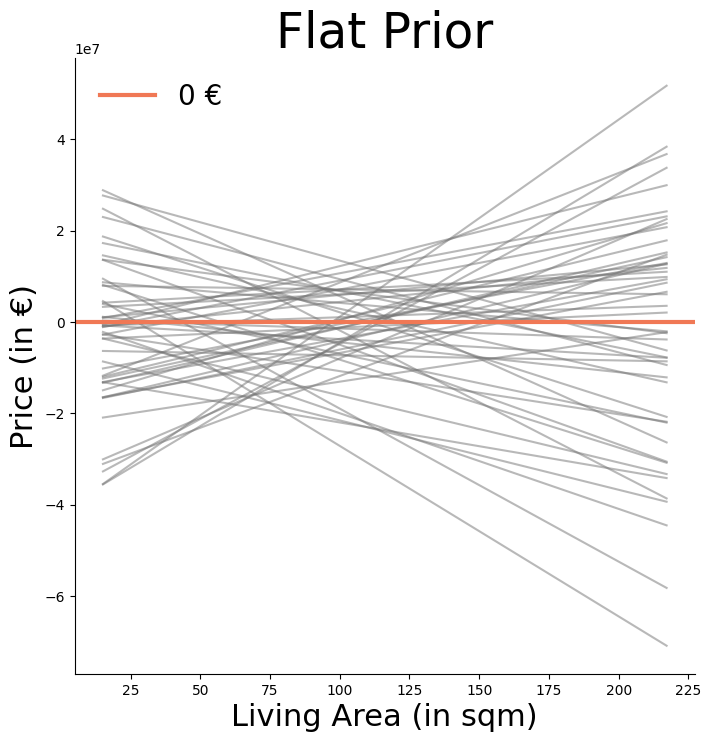

In [14]:
fig, ax2 = draw_model_plot(flat_prior, title="Flat Prior")
# ax2.axhline(y=8.5e6, c="#3d5167", label="Most expensive rent in Berlin", lw=3)
ax2.axhline(y=0, c="#f07855", label="0 €", lw=3)
ax2.legend(frameon=False, markerscale=3., fontsize=20)
#ax2.set_xlim(ax.get_xlim())
plt.show()

Our uninformed prior puts a lot of probability mass on implausible values. Michael Betancourt argues in his [case studies](https://mc-stan.org/users/documentation/case-studies/weakly_informative_shapes.html) that this means our priors are actually quite informative that pull the posterior towards extreme values and can thus (negatively) bias our inference. 

Computationally, it also means that the algorithm can take longer to converge since it unecessarily tries to explore values that are simply not plausible.

## Weakly informative prior

Many people nowadays argue for weakly informative priors instead of flat priors (see e.g. [Andrew Gelman](https://statmodeling.stat.columbia.edu/2007/05/11/weakly_informat/)). The idea is to capture the general scale of the data to give the algorithm some orientation without using overly specific priors. 

In our use case for example, we'd like the prior to put most probability mass between the reference values we identified above. The priors picked here are taken from the [default weakly informative priors](http://mc-stan.org/rstanarm/articles/priors.html) from the R package `rstanarm`.

In [15]:
# using different seeds just to get nicer plots
np.random.seed(12)

In [16]:
with pm.Model() as weakly_inf_prior:
    alpha = pm.Normal("alpha", mu=0, sd=20)
    beta = pm.Normal("beta", mu=0, sd=5)
    mu = alpha + beta*df["living_space_s"]
    
    sigma = pm.Exponential("sigma", lam = 1/2.5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df[target])
    
    weakly_inf_prior = pm.sample_prior_predictive()
    # weak_trace = pm.sample(draws=50, tune=50)

In [17]:
weakly_inf_data = az.from_pymc3(prior=weakly_inf_prior)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


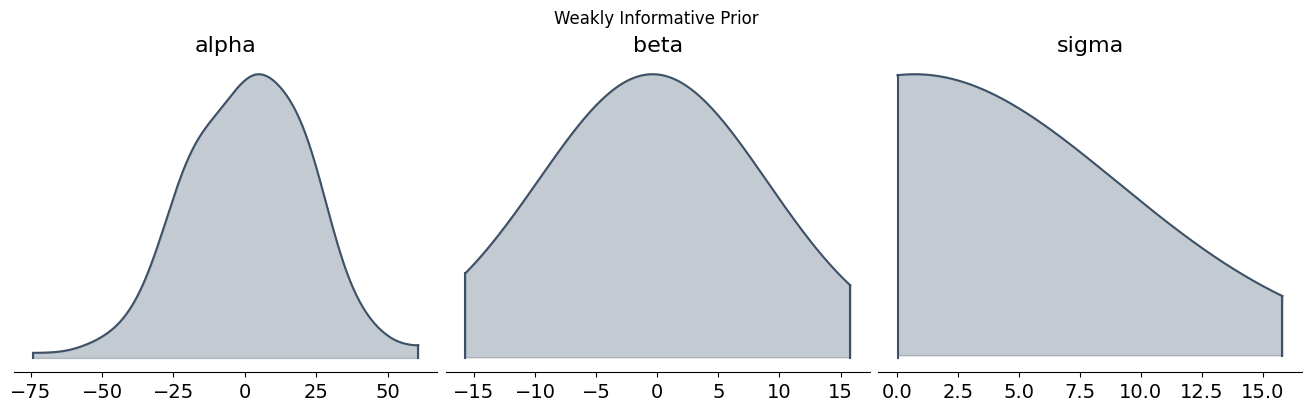

In [18]:
ax = az.plot_density(weakly_inf_data, group="prior",
                data_labels = ["weakly informative prior"],
               var_names = ["alpha", "beta", "sigma"],
               shade=0.3, bw=8, figsize=(13,4), hdi_prob=1,
                    colors="#3d5167", point_estimate=None)
# ax[0].set_xlim(-60, 60)
# ax[1].set_xlim(-15, 15)
# ax[2].set_xlim(0, 16)
# ax[0].set_title("alpha", fontdict={'fontsize': 20})
# ax[1].set_title("beta", fontdict={'fontsize': 20})
# ax[2].set_title("sigma", fontdict={'fontsize': 20})
# ax[0].set_xlabel("[Price of avg house in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[1].set_xlabel("[Price change in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[2].set_xlabel("[Price spread in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
plt.suptitle("Weakly Informative Prior")
plt.show()

Comparing this with the flat prior from before, this prior covers a much smaller range of values.

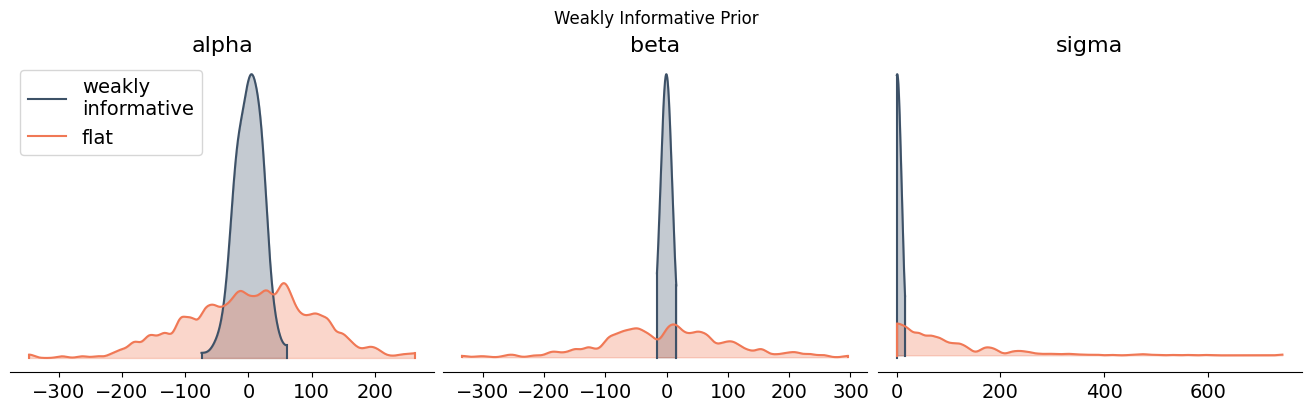

In [19]:
axes = az.plot_density([weakly_inf_data, flat_data], group="prior",
                data_labels = ["weakly\ninformative", "flat"],
               var_names = ["alpha", "beta", "sigma"],
               shade=0.3, bw=8, figsize=(13,4), hdi_prob=1, point_estimate=None,
                      colors=["#3d5167", "#f07855"])
# axes[0].set_xlim(-60, 60)
# axes[1].set_xlim(-15, 15)
# axes[2].set_xlim(0, 16)
# axes[0].legend(frameon=False, prop={'size': 18}, markerscale=3., loc="upper left")
# axes[0].set_title("alpha", fontdict={'fontsize': 20})
# axes[1].set_title("beta", fontdict={'fontsize': 20})
# axes[2].set_title("sigma", fontdict={'fontsize': 20})
# axes[0].set_xlabel("[Price of avg house in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# axes[1].set_xlabel("[Price change in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# axes[2].set_xlabel("[Price spread in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
plt.suptitle("Weakly Informative Prior")
plt.show()

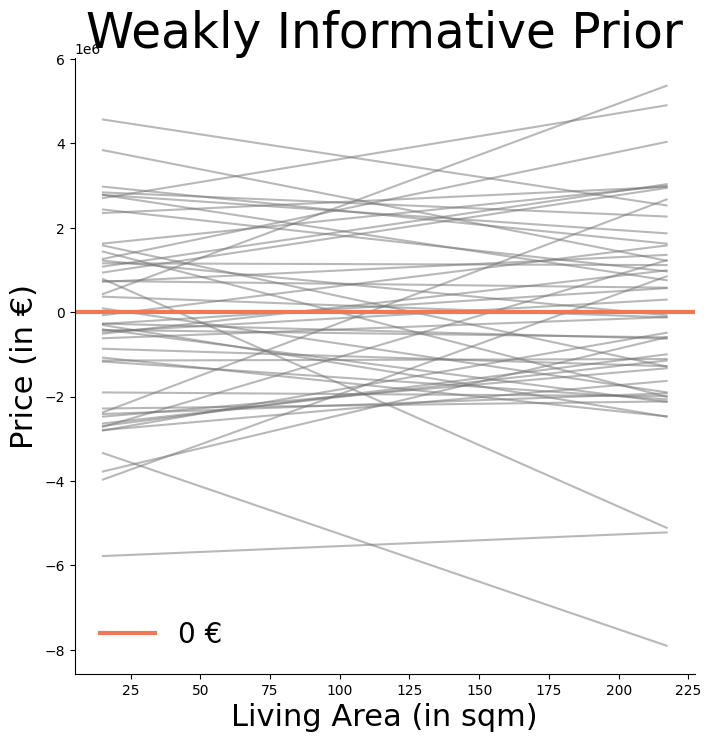

In [20]:
np.random.seed(1) # to get nicer plots
fig, ax = draw_model_plot(weakly_inf_prior, title="Weakly Informative Prior")
# ax.axhline(y=8.5e6, c="#3d5167", label="Most expensive flat sold in Berlin", lw=3)
ax.axhline(y=0, c="#f07855", label="0 €", lw=3)
ax.legend(frameon=False, markerscale=3., fontsize=20)
plt.show()

The models induced by this prior stays mostly within the scale of our reference points. It still puts a lot of probability mass on negative values (which we know can't happen) and also many models with a negative slope (meaning the homes get cheaper when they get bigger, unlikely to happen).
We could use this knowledge and generate an informed prior that takes this into account:

In [21]:
with pm.Model() as inf_prior:
    alpha = pm.Normal("alpha", mu=3, sd=2.5)
    beta = pm.Normal("beta", mu=1, sd=2)
    mu = alpha + beta*df["living_space_s"]
    
    sigma = pm.Exponential("sigma", lam = 1/2)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df[target])
    
    inf_prior = pm.sample_prior_predictive()
    # inf_trace = pm.sample(draws=50, tune=50)

In [22]:
inf_data = az.from_pymc3(prior=inf_prior)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


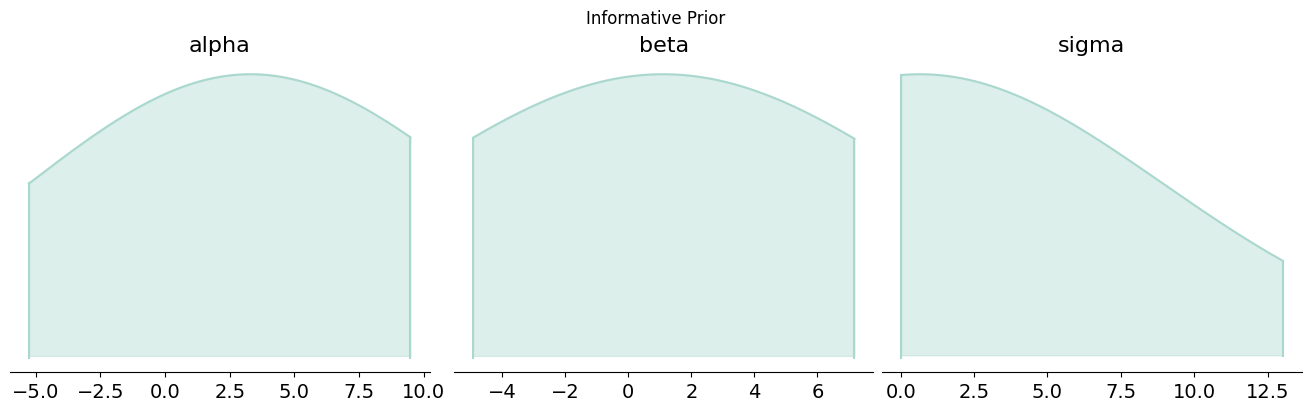

In [23]:
ax = az.plot_density(inf_data, group="prior",
                data_labels = ["informative prior"],
                  var_names = ["alpha", "beta", "sigma"],
               shade=0.4, bw=8, figsize=(13,4), hdi_prob=1,
                    colors="#abd8ce", point_estimate=None)
# ax[0].set_title("alpha", fontdict={'fontsize': 20})
# ax[1].set_title("beta", fontdict={'fontsize': 20})
# ax[2].set_title("sigma", fontdict={'fontsize': 20})
# ax[0].set_xlabel("[Price of avg house in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[1].set_xlabel("[Price change in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[2].set_xlabel("[Price spread in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
plt.suptitle("Informative Prior")
plt.show()

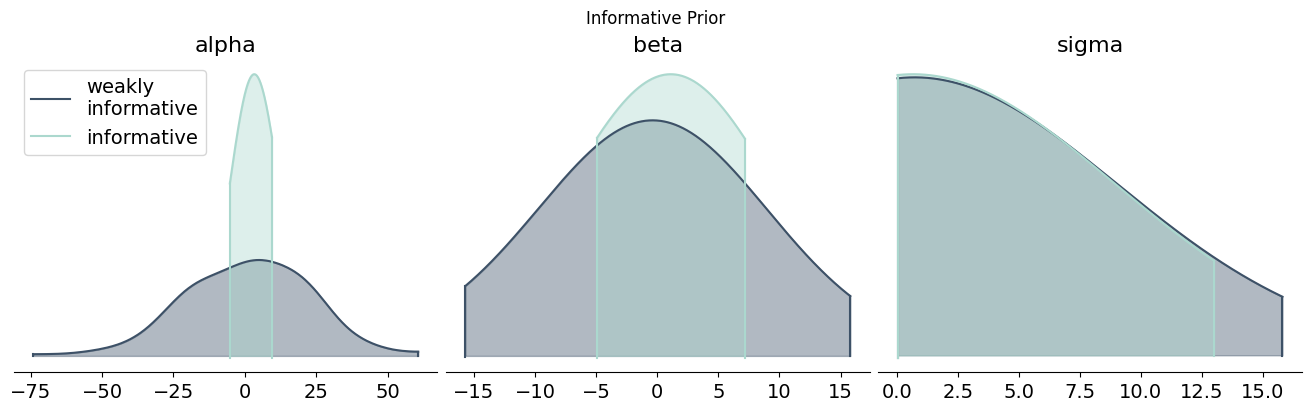

In [24]:
ax = az.plot_density([ weakly_inf_data, inf_data], group="prior",
                data_labels = ["weakly\ninformative", "informative"],
                  var_names = ["alpha", "beta", "sigma"],
               shade=0.4, bw=8, figsize=(13,4), hdi_prob=1,
                    colors=["#3d5167","#abd8ce"], point_estimate=None)
# ax[0].set_title("alpha", fontdict={'fontsize': 20})
# ax[1].set_title("beta", fontdict={'fontsize': 20})
# ax[2].set_title("sigma", fontdict={'fontsize': 20})
# ax[0].set_xlabel("[Price of avg house in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[1].set_xlabel("[Price change in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[2].set_xlabel("[Price spread in 100,000€]", fontdict={"fontsize": 18}, labelpad=15)
# ax[0].legend(frameon=False, prop={'size': 18}, markerscale=3., loc="upper left")
plt.suptitle("Informative Prior")
plt.show()

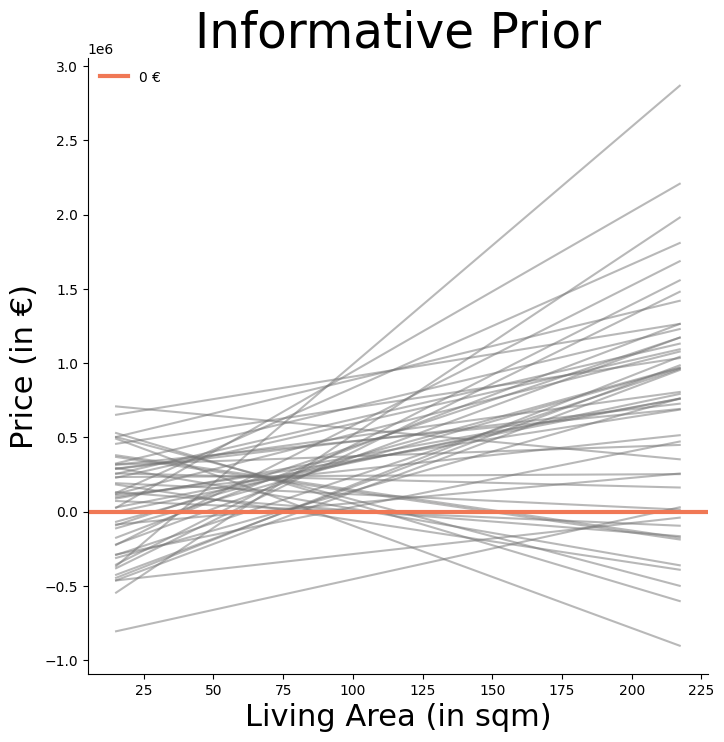

In [25]:
fig, ax = draw_model_plot(inf_prior, title="Informative Prior")
#ax.axhline(y=8.5e6, c="#3d5167", label="Most expensive flat sold in Berlin", lw=3)
ax.axhline(y=0, c="#f07855", label="0 €", lw=3)
ax.legend(frameon=False)
plt.show()

Even in this informed prior, we still allow the model to vary by quite a bit. There are still a few lines with a negative slope, but overall most slopes are positive and also above the 0-line.